
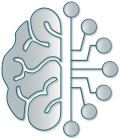

**Start at:** Monday 17 June 2024, 15:14:28  
**Hostname:** insa-20474 (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)

__author__ = "Matthieu CHARNAY, LPCNO (INSA-CNRS-UT3 lab, Toulouse, France)"

# Annexe au Modèle d'Ising par les portes quantiques

Afin de permettre au lecteur une certaine autonomie et efficience dans son étude, nous proposons ici une suite d'exemples variés de code. Ces exemples n'ont en eux même aucun lien avec le modèle d'Ising ou son circuit, mais présentent la syntaxe utile de MyQLM.

Chaque partie de cette annexe sera introduite par un simple titre, et éventuellement une rapide description du rôle du circuit.

Il sera laissé à charge du lecteur de savoir reconnaître les composantes du code dont il pourrait avoir besoin.

### Définition d'une routine

Il existe deux moyens de créer une routine : par déclaration d'un objet routine dans une fonction qui le retourne, ou par exploitation d'une procédure.

In [2]:
from qat.lang import qrout, H, CNOT, QRoutine

@qrout #le décorateur permet de définir qu'il s'agit d'une routine
def paire_bell_Routine1():
    H(0)
    CNOT(0,1)

#################

def paire_bell_Routine2():
    #cette fonction peut prendre des paramètres : on peut alors retourner des structures dépendant de paramètres (nb de qubits variable, etc...)
    rout=QRoutine()
    qreg=rout.new_wires(2)
    rout.apply(H,qreg[0])
    rout.apply(CNOT,qreg) #lorsqu'une porte s'applique sur tous les qubits, il est inutile de préciser les index
    return(rout)

### Définition d'une fonction

On peut également définir des fonctions qui agissent sur les qubits.

In [3]:
from qat.lang import qfunc

@qfunc
def paire_bell_fonction():
    H(0)
    CNOT(0,1)
    return[0,1] #nous devons cette fois-ci retourner les qubits dont nous nous sommes servis

#contrairement aux routines et programmes qui construisent des circuit, les fonctions ont pour but d'immédiatement fournir des résultats de mesure.

### Définition d'un programme

De même, un circuit est réalisable à partir d'un programme.

In [4]:
from qat.lang import Program

paire_bell_prog=Program() #on instancie un objet de la classe Program
qbits=paire_bell_prog.qalloc(2) #on alloue la mémoire pour 2 qbits
H(qbits[0]) #on travaille sur un tableau de qbits au lieu des indices directement
CNOT(qbits[0],qbits[1]) #on place toujours les qbits de contrôle en premier

#il existe une notation alternative :

paire_bell_prog2=Program()
qreg=paire_bell_prog2.qalloc(2)
paire_bell_prog2.apply(H,qreg[0])
paire_bell_prog2.apply(CNOT,qreg[0],qreg[1])

#nous pouvons également appliquer une routine au programme, pour ne pas avoir à remettre manuellement les même portes :

paire_bell_prog3=Program()
qreg2=paire_bell_prog3.qalloc(2)
paire_bell_prog3.apply(paire_bell_Routine2(),qreg) #lorsqu'une porte s'applique sur tous les qubits, il est inutile de préciser les index


### Compilons nos circuits

Après avoir défini tout cela, nous pouvons compiler des circuits et travailler dessus. Nous allons nous contenter pour l'instant de les afficher.

In [5]:
circ=paire_bell_prog.to_circ()
circ2=paire_bell_prog2.to_circ()
circ3=paire_bell_prog3.to_circ()
circ4=paire_bell_Routine1.to_circ()
circ5=paire_bell_Routine2().to_circ()

circ.display()
#circ2.display()
#circ3.display()
#circ4.display()
#circ5.display()
#nous obtenons évidemment systématiquement le même résultat

Quant à la fonction, nous pouvons immédiatement en tirer des états.

In [7]:
for sample in paire_bell_fonction():
    print(f"Etat {sample.state} amplitude {sample.amplitude} probabilité {sample.probability}")

Etat |00> amplitude (0.7071067811865475+0j) probabilité 0.4999999999999999
Etat |11> amplitude (0.7071067811865475+0j) probabilité 0.4999999999999999


### Processeur Quantique (qpu) virtuel

Une fois un circuit compilé, nous pouvons le simuler pour en tirer les états en sortie.

In [29]:
from qat.qpus import PyLinalg

qpu=PyLinalg() #on instance un processeur quantique
job=circ.to_job() #on créé un job à partir du circuit : c'est à ce stade qu'on peut préciser ce que l'on souhaite calculer exactement
resultats=qpu.submit(job) #on demande au qpu de traiter le job, et on en tire les résultats
for sample in resultats:
    print(f"Etat {sample.state} amplitude {sample.amplitude} probabilité {sample.probability}")

#un paramètre des jobs est nbshots, où l'on définit un nombre de mesure simulées ; par défaut, ou fixé à 0, celui-ci est pris comme pseudo-infini
job2=circ.to_job(nbshots=3) #3 est évidemment très faible comme nombre de mesures, les résultats seront fortement biaisés
resultats2=qpu.submit(job2)
print()
for sample in resultats2:
    print(f"Etat {sample.state} amplitude {sample.amplitude} probabilité {sample.probability}")
#il est alors intéressant de lancer le programme plusieurs fois et d'observer que les résultats obtenus varient sur cette seconde partie

Etat |00> amplitude (0.7071067811865475+0j) probabilité 0.4999999999999999
Etat |11> amplitude (0.7071067811865475+0j) probabilité 0.4999999999999999

Etat |00> amplitude None probabilité 0.6666666666666666
Etat |11> amplitude None probabilité 0.3333333333333333


### Portes quantiques abstraites

Il est possible de définir des portes abstraites, afin d'alléger l'affichage de nos circuits.

In [35]:
from qat.lang.AQASM import *

r"""On créé ici une porte abstraite dont le nom affiché dans le circuit sera mP
Son nom utilisé dans le code est maPorte (par soucis de clarté, il peut être perspicace d'utiliser le même nom en code et en affichage)
Le paramètre arity donne le nombre de qubits sur lesquels s'applique la porte
La porte abstraite n'a toujours pas d'implantation (paramètres circuit_generator ou matrix_generator...)
> si c'était le cas, elle prendrait en paramètres de son générateur deux paramètres : un entier et un flottant"""

maPorte = AbstractGate("mP",[int, float],arity=2)

#on peut lui ajouter une fonction à posteriori ; celle-ci doit retourner une routine

def routineQuelconque(n,f):
    #ce circuit est purement à but d'illustration, et ne remplit strictement aucune fonction
    qrout=QRoutine()
    qreg=qrout.new_wires(2)
    for i in range(n):
        qrout.apply(X,qreg[0])
    for j in range(int(f**n)):
        qrout.apply(H,qreg[1])
    return(qrout)

maPorte.set_circuit_generator(routineQuelconque)

### Matrice sur numpy

Il est important de savoir déclarer et utiliser une matrice avec numpy.

In [44]:
import numpy as np

test=np.array([[1,2,3],
              [4,5,6],
              [7,8,9]]) #une déclaration avec le code sous ce format (retours à la ligne) permet une meilleure lisibilité, mais n'est pas obligatoire
print(test)
print(test[0,2]) #1ere ligne, 3eme colonne

[[1 2 3]
 [4 5 6]
 [7 8 9]]
3


### Modification de portes pré-existantes

Il est possible de modifier des portes pré-existantes en leur ajoutant des caractéristiques (qubits de contrôle, dague...)

In [59]:
prog=Program()
qreg=prog.qalloc(5)
maPorte(0,0)(qreg[0:2]) #s'applique sur qreg[0] et qreg[1]
maPorte(1,1).ctrl()(qreg[0:3]) #le qubit 0, premier de la liste, prend le contrôle ; les deux autres subissent la porte
maPorte(2,2).ctrl().ctrl().ctrl()(qreg[0:5]) #les ctrl() supplémentaires s'ajoutent
maPorte(3,3).ctrl(3)(qreg) #il existe des notations équivalentes mais plus rapides
maPorte(4,4).dag()(qreg[1:3]) #on peut prendre les transconjuguées des portes

maPorte(5,5).ctrl(3).dag()(qreg[2:],qreg[:2]) #tout se combine ensemble

prog.to_circ().display()

### Mesure d'observable

Finalement, on peut mesurer des observables que nous définissons nous même.

In [76]:
from qat.core import Observable, Term
from qat.plugins import ObservableSplitter

nbZeros=Observable(5)

nbZeros.constant_coeff=2.5
for i in range(5):
    nbZeros.add_term(Term(0.5,"Z",[i]))
print(nbZeros) #calcul le nombre d'états 0 obtenus sur 5 qubits

prog=Program()
qreg=prog.qalloc(5)
for i in range(5):
    H(qreg[i])
circuit=prog.to_circ()
circuit.display()

qpu=ObservableSplitter()|PyLinalg()
job=circuit.to_job("OBS",observable=nbZeros,nbshots=4) #on précise bien que le job concerne un observable, que l'on donne ensuite
print("Nombre de zeros (4 mesures) : ",qpu.submit(job).value, "- moyenne variable à chaque exécution du code")
job2=circuit.to_job("OBS",observable=nbZeros)
print("Nombre de zeros (pseudo-infiniment de mesures) : ",qpu.submit(job2).value,"- moyenne fixe")

2.5 * I^5 +
0.5 * (Z|[0]) +
0.5 * (Z|[1]) +
0.5 * (Z|[2]) +
0.5 * (Z|[3]) +
0.5 * (Z|[4])


Nombre de zeros (4 mesures) :  2.5 - moyenne variable à chaque exécution du code
Nombre de zeros (pseudo-infiniment de mesures) :  2.5 - moyenne fixe
